In [66]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Construct Survey Correction Function

This is done for a single QPM mock here

Define correction factor as:
$\Phi(r_a,\mu_c) = \frac{4\pi V (\bar n\bar w)^2r_a^2\Delta r\delta \mu}{RR_a^c}$
in angular bin $c$, radial bin $a$.

#### Load in galaxy data-set to estimate $\bar n$, $\bar w$ and $V$.

In [32]:
gal_file = '/mnt/store1/oliverphilcox/DR12_QPM/processed/qpm_galaxy_1.xyzwj'
all_gal = np.loadtxt(gal_file)

In [33]:
gal_x = all_gal[:,0]
gal_y = all_gal[:,1]
gal_z = all_gal[:,2]
gal_w = all_gal[:,3]

In [27]:
gal_n = (1./gal_w-1.)/2000

In [29]:
norm2 = np.sum(gal_n*gal_w**2.)

In [18]:
N_gal = len(all_gal)
w_bar = mean(gal_w)

Find volume via ConvexHull

In [19]:
import scipy.spatial as ss
hull = ss.ConvexHull(np.vstack([gal_x,gal_y,gal_z]).T)
print('volume inside points is: ',hull.volume)
V=hull.volume # in (Mpc/h)^3

volume inside points is:  4039684687.8916426


In [20]:
n_bar = N_gal/V

#### Survey normalization

In [34]:
norm = 4.*pi*(n_bar*w_bar)**2.*V
print(norm)
norm = np.sum(gal_n*gal_w**2.)

36.039459361048486


#### Define bin widths and central radii

In [35]:
m = 1000

In [36]:
mu_cen = np.arange(1/(2*m),1+1/(2*m),1/m)

In [37]:
r_bins = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/radial_binning_cov.csv')
r_cen = mean(r_bins,axis=1)
delta_r = r_cen[-1]-r_cen[-2]
mu_cen = np.arange(1/(2*m),1.+1/(2*m),1/m)
delta_mu = mu_cen[-1]-mu_cen[-2]
n=len(r_cen)
m=len(mu_cen)

#### Load in data

In [67]:
RR_file = '/mnt/store1/oliverphilcox/Legendre2PCF/RR_counts_n35_m1000_11.txt'
RR_flat = np.loadtxt(RR_file)*np.sum(gal_w)**2.# must remove normalization factor

In [68]:
RR_true = RR_flat.reshape((n,m))

#### Define RR model

In [69]:
def RR_model(r_cen,mu):
    return norm2*r_cen**2.*delta_r*delta_mu

In [70]:
all_ratios = [RR_true[:,i]/RR_model(r_cen,mu_cen[i]) for i in range(m)]
if np.mean(all_ratios)>10:
    raise Exception("RR_true seems to be much larger than RR_model. Is the input RR correctly normalized?")
if np.mean(all_ratios)<0.1:
    raise Exception("RR_true seems to be much larger than RR_model. Is the input RR correctly normalized?")

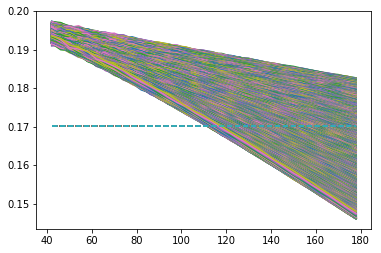

In [71]:
for i in range(m):
    plt.plot(r_cen,RR_true[:,i]/r_cen**2,ls='-')
    plt.plot(r_cen,RR_model(r_cen,mu_cen[i])/r_cen**2.,ls='--')

#### Find $\Phi$ functions

In [72]:
Phi_values = []
for r_bin in range(n):
    Phi_values.append(RR_model(r_cen[r_bin],mu_cen)/RR_true[r_bin,:])
    

In [73]:
np.asarray(Phi_values).shape

(35, 1000)

In [74]:
r_cen.shape

(35,)

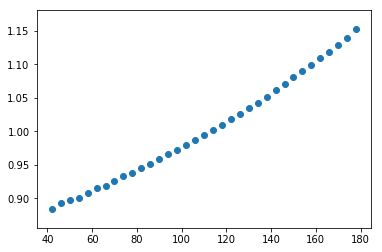

In [75]:
plt.scatter(r_cen,np.asarray(Phi_values)[:,900])

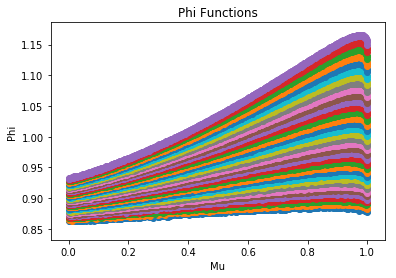

In [53]:
for i in range(n):
    plt.scatter(mu_cen,Phi_values[i]);
plt.title('Phi Functions')
plt.ylabel('Phi');plt.xlabel('Mu');

#### Fit to smooth function

Pick the piecewise continuous function;
$$\Phi(r_a,\mu) = \begin{cases} a_0+a_1\mu +a_2\mu^2& \text{ if }\mu<0.75\\ b_0+b_1\mu+b_2\mu^2+b_3\mu^3 & \text{ if }\mu \geq 0.75\end{cases}$$
with $b_0$ and $b_1$ set by imposing that $\Phi$ and $d\Phi/d\mu$ are continuous at $\mu=0.75$.

In [462]:
mu_crit=0.75

In [463]:
def Phi_model(mu,a0,a1,a2,b2,b3,mu_crit=mu_crit):
    b1=a1+2*mu_crit*(a2-b2)-3*b3*mu_crit**2.
    b0=a0+(a1-b1)*mu_crit+(a2-b2)*mu_crit**2.-b3*mu_crit**3.
    filt1=np.where(mu<mu_crit)
    filt2=np.where(mu>=mu_crit)
    output=np.zeros_like(mu)
    output[filt1]=a0+a1*mu[filt1]+a2*mu[filt1]**2.
    output[filt2]=b0+b1*mu[filt2]+b2*mu[filt2]**2.+b3*mu[filt2]**3.
    return output

In [464]:
def fit_model(mu,good_param):
    return Phi_model(mu,good_param[0],good_param[1],good_param[2],good_param[3],good_param[4])

fit_params=[]
errors=[]
for i in range(n):
    good_param,_=curve_fit(Phi_model,mu_cen,Phi_values[i],p0=[0,0,0,0,0])
    a0,a1,a2,b2,b3=good_param
    b1=a1+2*mu_crit*(a2-b2)-3*b3*mu_crit**2.
    b0=a0+(a1-b1)*mu_crit+(a2-b2)*mu_crit**2.-b3*mu_crit**3.
    out_params=[a0,a1,a2,b0,b1,b2,b3]
    fit_params.append(out_params)
    errors.append(np.abs(Phi_values[i]-fit_model(mu_cen,good_param))/fit_model(mu_cen,good_param))
    

In [465]:
fit_params = np.asarray(fit_params)

Now save to file:

In [466]:
np.savetxt('/mnt/store1/oliverphilcox/Legendre2PCF/BinCorrectionFactor_n%d.txt'%n,fit_params)

### Do some graphical testing

In [467]:
test_index=20
good_param,_=curve_fit(Phi_model,mu_cen,Phi_values[test_index],p0=[0,0,0,0,0])

def fit_model(mu):
    return Phi_model(mu,good_param[0],good_param[1],good_param[2],good_param[3],good_param[4])

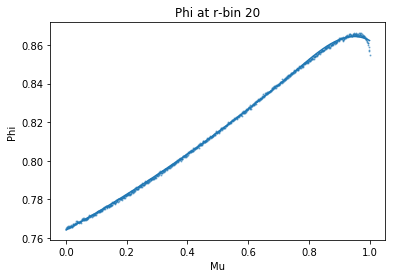

In [468]:
plt.plot(mu_cen,fit_model(mu_cen))
plt.scatter(mu_cen,Phi_values[test_index],alpha=0.5,s=1)
#plt.xlim([0.7,1])
plt.ylabel('Phi');plt.xlabel('Mu');plt.title('Phi at r-bin %d'%test_index);

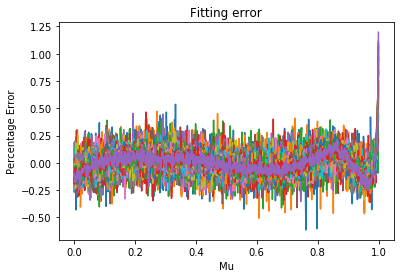

In [469]:
for i in range(n):
    good_param,_=curve_fit(Phi_model,mu_cen,Phi_values[i],p0=[0,0,0,0,0])

    def fit_model(mu):
        return Phi_model(mu,good_param[0],good_param[1],good_param[2],good_param[3],good_param[4])
    
    plt.plot(mu_cen,(fit_model(mu_cen)-Phi_values[i])/fit_model(mu_cen)*100.)
plt.title('Fitting error')
plt.xlabel('Mu')
plt.ylabel('Percentage Error');

In [470]:
d=np.loadtxt('/mnt/store1/oliverphilcox/Legendre2PCF/BinCorrectionFactor_n35_m1000.txt')